In [62]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import recordlinkage
from sklearn.feature_extraction.text import TfidfVectorizer
## nltk imports
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
# ! pip install xlrd
# ! pip install openpyxl
## lda 
from gensim import corpora
import gensim
import matplotlib.pyplot as plt # rj note- this import was mssing from the script

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## define constants and pathnames
GITHUB_DATA_PATH = "../data/"
DROPBOX_DATA_PATH = "/qss20_finalproj_rawdata/textasdata/"
COMBINED_DISCLOSURE_DATA = "H-2A_Disclosure_Data_FY_combined_202021Q1.csv"
COMBINED_ADDENDUMS_DATA = "FOIA_2021-F-05932_raw_data_combined_202021Q1.csv"

# Load datasets

In [120]:
# load data
addendum = pd.read_csv("../FOIA_2021-F-05932_raw_data_combined_202021Q1.csv")
disclosure = pd.read_csv ("../H-2A_Disclosure_Data_FY_combined_202021Q1.csv")

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (17,18,31,83,84,138,139) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Clean disclosure data

- Dropping duplicates

In [121]:
print("Before dropping duplicates, %s rows" % len(disclosure))
disclosure = disclosure.drop_duplicates(["CASE_NUMBER"])
print("After dropping duplicates, %s rows" % len(disclosure))

Before dropping duplicates, 16783 rows
After dropping duplicates, 16774 rows


# Aggregate addendums data

- Dropping duplicates
- Rename Column
- Joining free text
- Removing ones with Spanish

In [122]:
print("Before dropping duplicates, %s rows" % len(addendum))
addendum = addendum.drop_duplicates(["CASE_NUMBER", "SECTION_DETAILS"])
print("After dropping duplicates, %s rows" % len(addendum))

Before dropping duplicates, 102317 rows
After dropping duplicates, 99620 rows


In [123]:
# Rename Columns in aggregated addendums
addendum = addendum.rename(columns = {"SECTION_DETAILS":"JOB_DESCRIPTION"})

In [124]:
#Remove Job Listings that Contain Spanish Words
## rj note: not high priority, but i have some concerns about doing this 
## removal on the aggregated addendums rather than the sections
## in particular, it might make more sense to do the spanish indicator on whether a specific section
## contains spanish and then remove that section; preserving non-spanish sections of that posting
## this discards the whole post if any section contains spanish, which ends up deleting more data
spanish_words = ['compensación',
 'ocupación',
 'pago',
 'transporte',
 'reglas',
 'contrato',
 'horastrabajadores',
 'parte',
 'tarifas',
 'cuartos',
 'trabajo',
 'registros',
 'adicionales',
 'comidas',
 'empleo',
 'terminación',
 'vivienda',
 'empleador',
 'adicionales',
 'frecuencia',
 'producción',
 'liquidación',
 'comida',
 'herramientas',
 'prueba',
 'diaria',
 'tarifas',
 'parado',
 'adicionales',
 'cobertura',
 'proporcionados',
 'parte',
 'abandono',
 'deducciones',
 'causa',
 'garantías',
 'divulgación',
 'comidas',
 'política',
 'disciplina',
 'despidos',
 'derechos',
 'imposibilidad',
 'detalles',
 'divulgación',
 'bloqueo',
 'abandono',
 'ganancias',
 'cobertura',
 'pedidos',
 'pago',
 'oportunidad',
 'trabajo']

addendum['is_contains_spanish'] = np.where(addendum.JOB_DESCRIPTION.str.contains('|'.join(spanish_words)),
                                              True, False)

addendum_eng = addendum[~addendum.is_contains_spanish].copy()
print("Removing addendums with any spanish takes us from {} jobs to {} jobs".format(
        len(addendum.CASE_NUMBER.unique()),
        len(addendum_eng.CASE_NUMBER.unique())))


Removing addendums with any spanish takes us from 13535 jobs to 13143 jobs


In [128]:
#Concatenating English Job Lisitngs from Same Case

addendum_eng_agg = addendum_eng.groupby(['CASE_NUMBER'])['JOB_DESCRIPTION'].apply(lambda text: ''.join(text.to_string(index=False))).str.replace('(\\n)', '').reset_index()
print("After pasting together addendums from same case, %s rows" % len(addendum_eng_agg))
assert len(addendum_eng_agg) == len(addendum_eng.CASE_NUMBER.unique())


After pasting together addendums from same case, 13143 rows


<ipython-input-128-f1789783c14d>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  addendum_eng_agg = addendum_eng.groupby(['CASE_NUMBER'])['JOB_DESCRIPTION'].apply(lambda text: ''.join(text.to_string(index=False))).str.replace('(\\n)', '').reset_index()


In [ ]:
## Above code modified from fifth answer at https://stackoverflow.com/questions/27298178/concatenate-strings-from-several-rows-using-pandas-groupby
## because original groupby was including a bunch of linebreaks

# Merge the addendums data to disclosure data

- Clean up state in the disclosure data
- Create indicate for TRLA catchment area
- Create diff merges

RJ note: originally, this had a lot of stuff related to the disclosure data but since we're doing a left join of addendums onto disclosures, and comparing jobs in two categories---"left only" (disclosure with no addendum) and "both" (disclosure with addendum)---we can delete most of the disclosure stuff post merge and just use left-joined df

In [130]:
## rj note: might want to consider allowing employer_poc_state to count
## as state but left as is
## i left in ones with missing states and they're just false for TRLA catchment

#Replace EMPLOYER_STATE NA with employer_poc_state State is there's a value but left NA if both of them are NA
disclosure = pd.read_csv ("../H-2A_Disclosure_Data_FY_combined_202021Q1.csv")
disclosure['EMPLOYER_STATE'] =disclosure.EMPLOYER_STATE.astype("string")
print("number of NA in EMPLOYER_STATE column before allowing employer_poc_state to count as state")
disclosure['EMPLOYER_STATE'].isna().sum()
disclosure['EMPLOYER_POC_STATE'] =disclosure.EMPLOYER_POC_STATE.astype("string")
disclosure.EMPLOYER_STATE = disclosure.EMPLOYER_STATE.fillna(disclosure.EMPLOYER_POC_STATE)
print("number of NA in EMPLOYER_STATE column after allowing employer_poc_state to count as state")
disclosure['EMPLOYER_STATE'].isna().sum()




number of NA in EMPLOYER_STATE column before allowing employer_poc_state to count as state


16

number of NA in EMPLOYER_STATE column after allowing employer_poc_state to count as state


12

In [131]:
# Label TRLA Catchment State VS Remaining States
## rj note- isin more efficient than long or chain
TRLA_catchment = ["TX", "MS", "AL", "TN", "KY", "LA"]
disclosure["TRLA"] = np.where(disclosure.EMPLOYER_STATE.isin(TRLA_catchment), True, False)
disclosure.TRLA.value_counts(normalize = True)

False    0.713937
True     0.286063
Name: TRLA, dtype: float64

In [132]:
## left join addendums onto disclosures 
## using case number
## rj note- i'm just merging english addendums (addendum_eng_agg)
## to keep code consistent but you may want to add back
## the spanish ones (addendum)
merged_data_left = pd.merge(disclosure,
                             addendum_eng_agg,
                             left_on = 'CASE_NUMBER',
                             right_on = 'CASE_NUMBER',
                             how = "left",
                             indicator = "case_merge_status")
merged_data_left.case_merge_status.value_counts()

both          13136
left_only      3647
right_only        0
Name: case_merge_status, dtype: int64

# Diagnostics of ones with and without english addendums

In [133]:
## rj note: i cleaned this up to just use the full left join
merged_data_left[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes

## rj note; combining data w/ code rather than excel
## kept this as float rather than as string ($) might have been an 
## excel formatting thing so kept this code in case issue reoccurs
## but probally fine to delete:
if merged_data_left.dtypes['WAGE_OFFER'] != "float64":
      
    merged_data_left['WAGE_OFFER'] = merged_data_left['WAGE_OFFER'].str.replace('$', '')
    merged_data_left['WAGE_OFFER'] = merged_data_left['WAGE_OFFER'].str.replace(',', '')
    merged_data_left['WAGE_OFFER'] = merged_data_left['WAGE_OFFER'].astype(float)
        
merged_data_left[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes

ANTICIPATED_NUMBER_OF_HOURS    float64
WAGE_OFFER                     float64
TOTAL_WORKERS_NEEDED           float64
dtype: object

ANTICIPATED_NUMBER_OF_HOURS    float64
WAGE_OFFER                     float64
TOTAL_WORKERS_NEEDED           float64
dtype: object

In [134]:
## add more informative column
merged_data_left['case_merge_status_descriptive'] = np.where(merged_data_left.case_merge_status == 
                                                        "left_only",
                                                        "No English addendum",
                                                        "English addendum")
merged_data_left.groupby('case_merge_status_descriptive').agg(
        {
         "WAGE_OFFER": ["median"],
         "TOTAL_WORKERS_NEEDED": ["median"],
        "ANTICIPATED_NUMBER_OF_HOURS": ["median"],
        "PIECE_RATE_OFFER": ["median"],
        "WORK_EXPERIENCE_MONTHS" : ["median"],
        "TOTAL_OCCUPANCY" : ["median"],
        "LIFTING_AMOUNT" : ["median"],
        "TRLA": np.mean} # rj note: added TRLA to hear since we can just take mean
        )

#percentage of non TRLA states is higher
#compare wages? is it that there's lower wage rate so there's no listing?


,WAGE_OFFER,TOTAL_WORKERS_NEEDED,ANTICIPATED_NUMBER_OF_HOURS,PIECE_RATE_OFFER,WORK_EXPERIENCE_MONTHS,TOTAL_OCCUPANCY,LIFTING_AMOUNT,TRLA
,median,median,median,median,median,median,median,mean
case_merge_status_descriptive,,,,,,,,
English addendum,13.48,6.0,40.0,0.0,3.0,8.0,60.0,0.280527
No English addendum,13.13,4.0,40.0,0.0,3.0,6.0,50.0,0.306005


## Plot breakdown of addendums by TRLA or not 

### Pie chart

In [117]:
merged_data_left.case_merge_status.value_counts()

both          74888
left_only      3647
right_only        0
Name: case_merge_status, dtype: int64

[2531, 1116]

[57151, 17737]

([<matplotlib.patches.Wedge at 0x7f3a9e615af0>,
 [Text(-0.6296613361890455, 0.9019570952704047, 'Non-TRLA'),
  Text(0.6296613361890454, -0.9019570952704048, 'TRLA')],
 [Text(-0.3434516379212975, 0.4919765974202207, '69.4%'),
  Text(0.34345163792129746, -0.49197659742022076, '30.6%')])

Text(0.5, 1.0, 'Jobs without English addendums\n(not in text analysis)')

Text(0.5, 1.0, 'Jobs with English addendums\n(in text analysis)')

([<matplotlib.patches.Wedge at 0x7f3a8de80af0>,
 [Text(-0.8092847446980336, 0.7450222828875918, 'Non-TRLA'),
  Text(0.8092847098210224, -0.7450223207729441, 'TRLA')],
 [Text(-0.44142804256256374, 0.4063757906659591, '76.3%'),
  Text(0.4414280235387395, -0.4063758113306967, '23.7%')])

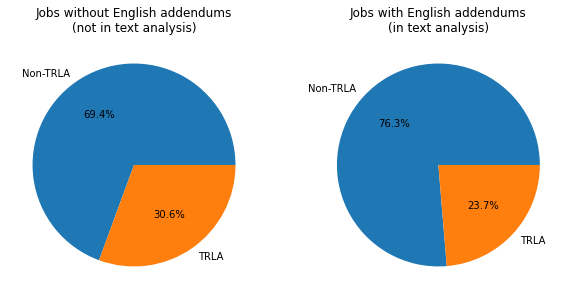

In [118]:
no_add = [merged_data_left[(merged_data_left.case_merge_status == "left_only") &
                     (~merged_data_left.TRLA)].shape[0],
            merged_data_left[(merged_data_left.case_merge_status == "left_only") &
                     (merged_data_left.TRLA)].shape[0]]
no_add

add = [merged_data_left[(merged_data_left.case_merge_status == "both") &
                     (~merged_data_left.TRLA)].shape[0],
            merged_data_left[(merged_data_left.case_merge_status == "both") &
                     (merged_data_left.TRLA)].shape[0]]
add
labels = ['Non-TRLA', 'TRLA'] 
fig, (plt1,plt2) = plt.subplots(1,2,figsize=(10,10))
plt1.pie(no_add, labels=labels, autopct='%1.1f%%')
plt1.set_title("Jobs without English addendums\n(not in text analysis)")
plt2.set_title("Jobs with English addendums\n(in text analysis)")
plt2.pie(add, labels=labels, autopct='%1.1f%%')

# Write outputs for next script

- pkl and csv (in case linebreak) of inner join between (1) disclosure and (2) aggregated, English-only addendums

In [135]:
## same join as above but inner join rather than left join
merged_data_inner = pd.merge(disclosure,
                             addendum_eng_agg,
                             left_on = 'CASE_NUMBER',
                             right_on = 'CASE_NUMBER',
                             how = "inner")
merged_data_inner.shape

## write pkl and csv form to Dropbox folder
merged_data_inner.to_csv("../merged_addendums_jobdisclosures.csv",
                        index = False)
merged_data_inner.to_pickle("../merged_addendums_jobdisclosures.pkl")

(13136, 142)